In [7]:
#INSTALLING ALL THE REQUIRED LIBRARIES


!pip install matplotlib
!pip install nibabel
!pip install scikit-image
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
# DATASET LOADING

import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
data = nib.load("3702_left_knee.nii").get_fdata()

print('Shape of the dataset : ',data.shape)



Shape of the dataset :  (512, 512, 216)


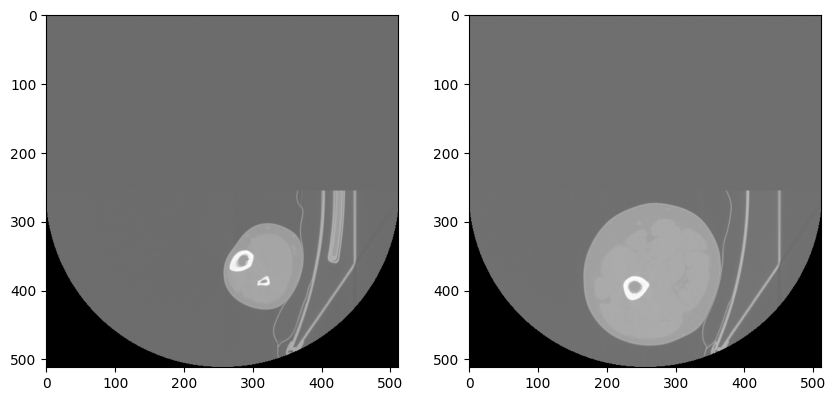

In [9]:
#VISUALIZATION OF DATASET

dt1 = data[:, :, 0]
dt2 = data[:, :, 215] 


plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(dt1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(dt2, cmap = 'gray')
            
plt.show()

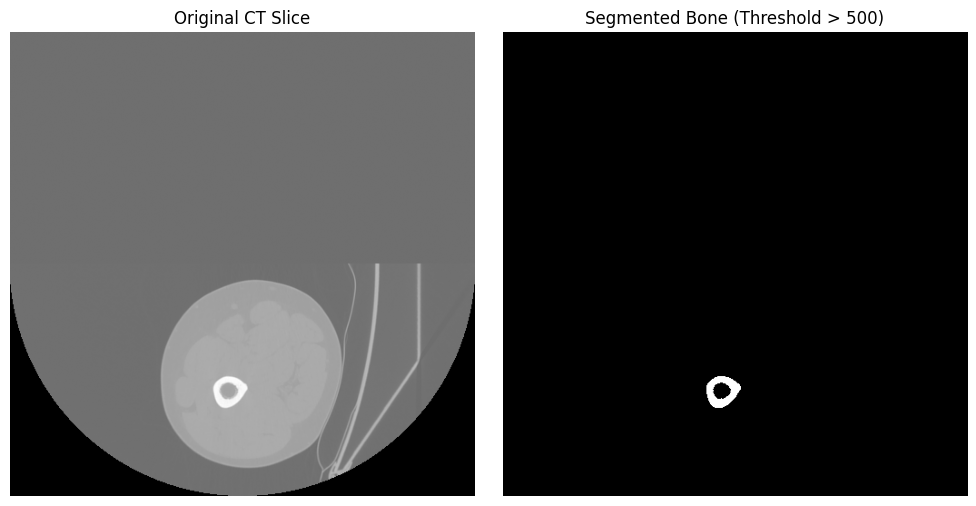

In [21]:
# TASK 1.1 :  BONE SEGMENTATION 

import numpy as np
import matplotlib.pyplot as plt

# Thresholding (for bone)
# Reference for selection of threshold : https://radiopaedia.org/articles/hounsfield-unit?lang=gb

# Parameters
segmentation_threshold = 500
index = 215

# Actual segmentation operation, which returns all values in Boolean
segmented_images = data > segmentation_threshold


# Sampling an image
original_image = data[:,:,index]
segmented_image = segmented_images[:,:,index]

# Display side-by-side
plt.figure(figsize=(10, 5))

# Original grayscale CT slice
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

# Segmented bone mask
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Bone (Threshold > 500)")
plt.axis('off')

plt.tight_layout()
plt.show()




In [22]:
from scipy.ndimage import label

# computing the number of connected components
labeled_arrays, num_features = label(segmented_images)

print(f"Found {num_features} components")




Found 400 components


The Image is of Upper Leg and contains femur
{1: np.int64(719)}


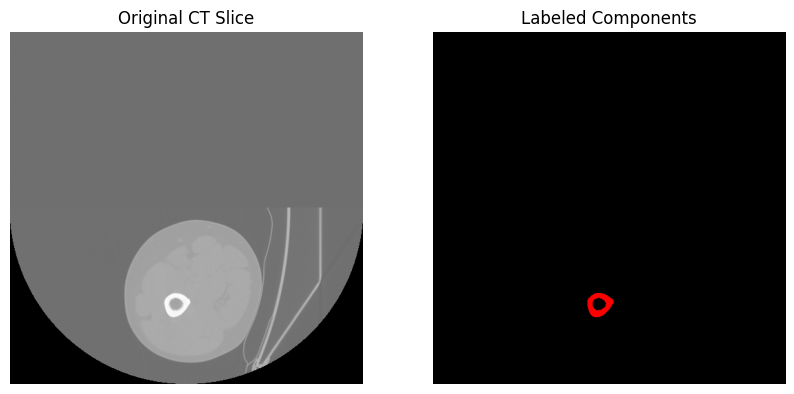

In [23]:
#TIBULA(GREEN) AND FEMUR SEGMENTATION(RED)

labeled_array, num_features = label(segmented_image)
binary_mask = labeled_array



temparr1 = np.zeros((512,512), dtype = int)
temparr2 = np.zeros((512,512), dtype = int)


if num_features == 1:
    print('The Image is of Upper Leg and contains femur')
    area = {i : (labeled_array == i).sum() for i in range(1, num_features+1)}
    print(area)

    plt.figure(figsize=(10, 5))


    labeled_array = np.stack((labeled_array, temparr1, temparr2), axis = 2)
    labeled_array = labeled_array * 255

    
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array, cmap='gray')  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()

else: 
    print('The Image is of Lower Leg, and contains tibula and fibula')
    area = {i : int((labeled_array == i).sum()) for i in range(1, num_features+1)}
    # checking area inorder to find tibula
    print(area)
    maximum_area = 0
    maximum_area_component = None
    for key, value in area.items():
        if value>maximum_area:
            maximum_area = value
            maximum_area_component = key
    print('Maximum Area Component : ', maximum_area_component,' with area of : ', maximum_area)
    print('Hence, component', maximum_area_component,'is Tibula')

    #Hiding fibula
    labeled_array[labeled_array != maximum_area_component] = 0

    print(labeled_array.shape)
    plt.figure(figsize=(10, 5))

    
    labeled_array = np.stack((temparr1, labeled_array, temparr2), axis = 2)
    labeled_array = labeled_array * 255
    print(labeled_array.shape)
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, index], cmap='gray')
    plt.title("Original CT Slice")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled_array)  # Use colorful colormap
    plt.title("Labeled Components")
    plt.axis('off')
    
    plt.show()




In [13]:
area = [(labeled_array == i).sum() for i in range(1, num_features+1)]
# val = True
# print(int(val))
area

[np.int64(0)]

In [24]:
#TASK 2.2 : EXPANSION OF THE COUNTOUR OF MASK

import numpy as np
from skimage.morphology import binary_dilation, disk, ellipse
from skimage import measure

def expand_mask_by_mm(mask, spacing, expansion_mm=2.0):
    # Calculate number of pixels to match expansion_mm
    pixels_y = int(round(expansion_mm / spacing[0]))
    pixels_x = int(round(expansion_mm / spacing[1]))

    # Create an elliptical structuring element to match anisotropic spacing
    selem = ellipse(pixels_y, pixels_x)
    
    # Expand the mask
    expanded_mask = binary_dilation(mask, selem)
    return expanded_mask



(512, 512)


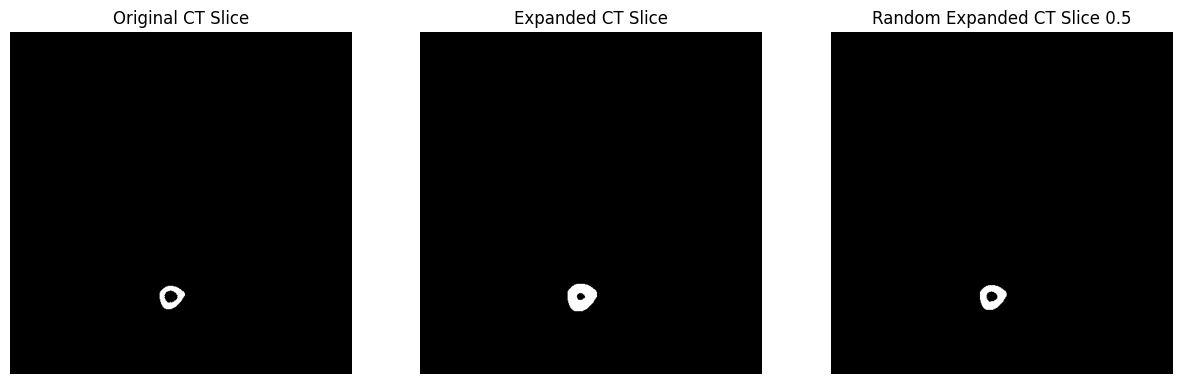

In [26]:
# TASK 1.3 : RANDOM CONTOUR EXPANSION
# Example binary mask and spacing (e.g., 0.5 mm/pixel)

# spacing = (row_spacing_mm, col_spacing_mm)
# expansion_mm = 2.0
# random_level = 0.4 (40% of the way from original to full expansion)


spacing = (0.5, 0.5)  # (x, y) in mm/pixel



expanded = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0)

ratio_of_expansion = 0.5

randomized = expand_mask_by_mm(binary_mask, spacing=(0.7, 0.7), expansion_mm=2.0 * ratio_of_expansion)
print(expanded.shape)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(binary_mask, cmap='gray')
plt.title("Original CT Slice")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(expanded, cmap='gray')  # Use colorful colormap
plt.title("Expanded CT Slice")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(randomized, cmap='gray')  # Use colorful colormap
plt.title(f"Random Expanded CT Slice {ratio_of_expansion}")
plt.axis('off')

plt.show()

(512, 512, 216)
0.5
(512, 512, 216) (512, 512, 216)


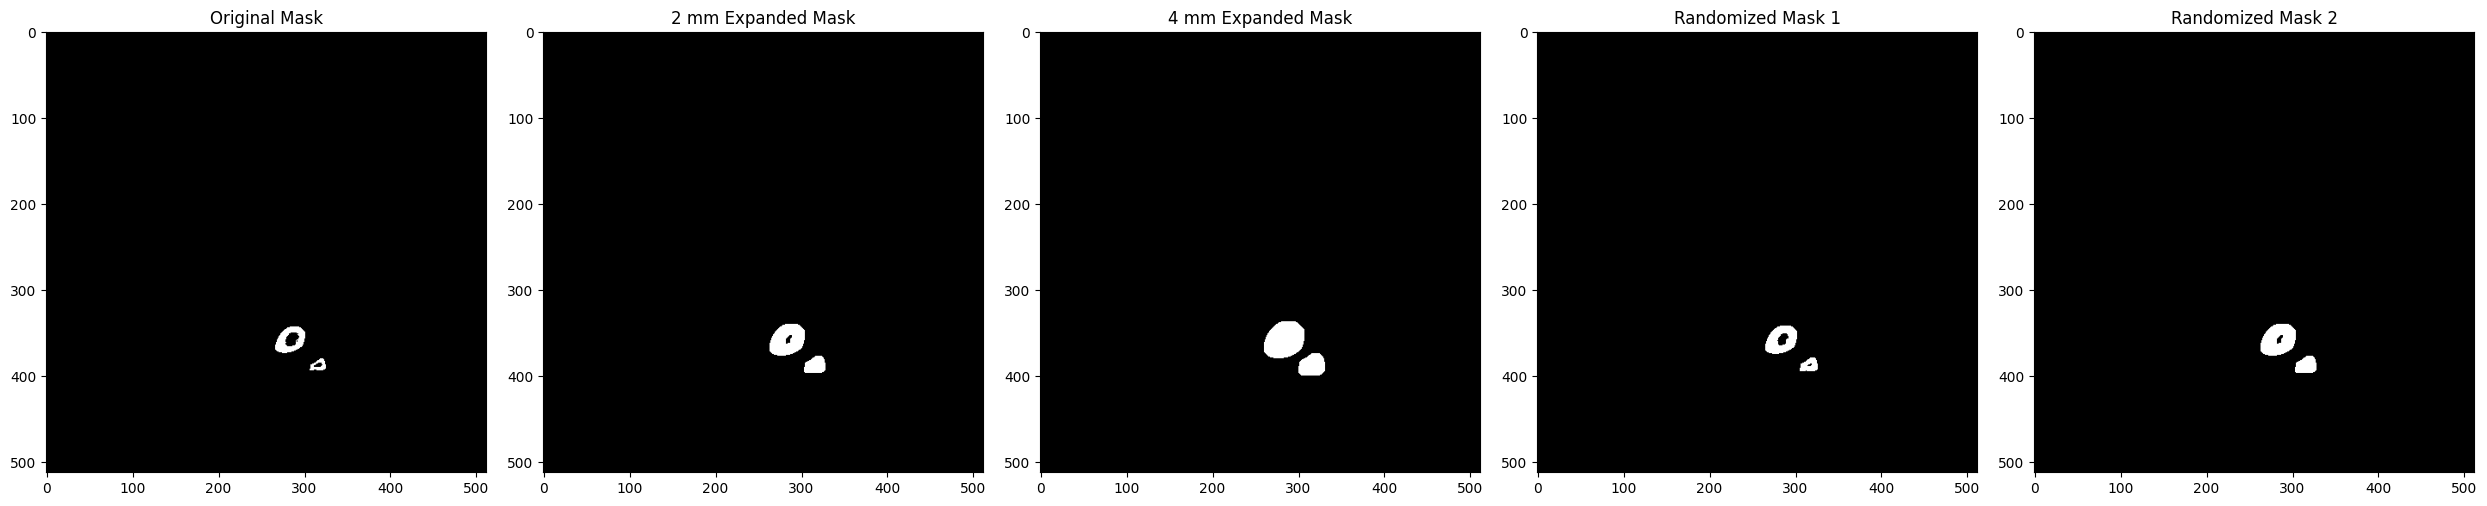

In [27]:
# TASK 1.4 : SACHING ORIGINAL MASK, MASK WITH CONTOUR EXPANSION OF 2mm and 4mm, AND TWO KINDS OF RANDOM CONTOUR EXPANSION

mask_2_list = []
mask_4_list = []
random_1_list = []
random_2_list = []



original_masks = data > segmentation_threshold


print(original_masks.shape)
#EXPANSION OF THE COUNTOUR OF MASK

print(ratio_of_expansion)

mask_2_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=2.0) for idx in range(0, original_masks.shape[2])]
mask_4_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=4.0) for idx in range(0, original_masks.shape[2])]
random_1_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=2.0 * ratio_of_expansion) for idx in range(0, original_masks.shape[2])]
random_2_list = [expand_mask_by_mm(original_masks[:,:,idx], spacing=(0.7, 0.7), expansion_mm=4.0 * ratio_of_expansion) for idx in range(0, original_masks.shape[2])]


mask_2 = np.stack(mask_2_list, axis = 2)
mask_4 = np.stack(mask_4_list, axis = 2)
random_1 = np.stack(random_1_list, axis = 2)
random_2 = np.stack(random_2_list, axis = 2)

print(mask_2.shape, mask_4.shape)

idx_to_display = 0

import matplotlib.pyplot as plt

idx_to_display = 0  # Index of the slice to visualize

plt.figure(figsize=(25, 5))

plt.subplot(1, 5, 1)
plt.imshow(original_masks[:, :, idx_to_display], cmap='gray')
plt.title("Original Mask")

plt.subplot(1, 5, 2)
plt.imshow(mask_2[:, :, idx_to_display], cmap='gray')
plt.title("2 mm Expanded Mask")

plt.subplot(1, 5, 3)
plt.imshow(mask_4[:, :, idx_to_display], cmap='gray')
plt.title("4 mm Expanded Mask")

plt.subplot(1, 5, 4)
plt.imshow(random_1[:, :, idx_to_display], cmap='gray')
plt.title("Randomized Mask 1")

plt.subplot(1, 5, 5)
plt.imshow(random_2[:, :, idx_to_display], cmap='gray')
plt.title("Randomized Mask 2")


plt.tight_layout()
plt.show()


In [28]:
# Print shapes for confirmation
print("Original Mask Shape:", original_masks.shape)
print("2mm Expanded Mask Shape:", mask_2.shape)
print("4mm Expanded Mask Shape:", mask_4.shape)
print("Randomized Mask 1 Shape:", random_1.shape)
print("Randomized Mask 2 Shape:", random_2.shape)

# Load the affine from your original NIfTI file
# Replace 'original_mask_file.nii.gz' with the correct file
original_nifti = nib.load('3702_left_knee.nii')
affine = original_nifti.affine

# Create a dictionary of filenames and arrays
masks = {
    'original_mask.nii.gz': original_masks,
    'expanded_2mm.nii.gz': mask_2,
    'expanded_4mm.nii.gz': mask_4,
    'randomized_1.nii.gz': random_1,
    'randomized_2.nii.gz': random_2,
}

# Save each mask
for filename, array in masks.items():
    nifti_img = nib.Nifti1Image(array.astype(np.uint8), affine)
    nib.save(nifti_img, filename)
    print(f"Saved {filename}")

Original Mask Shape: (512, 512, 216)
2mm Expanded Mask Shape: (512, 512, 216)
4mm Expanded Mask Shape: (512, 512, 216)
Randomized Mask 1 Shape: (512, 512, 216)
Randomized Mask 2 Shape: (512, 512, 216)
Saved original_mask.nii.gz
Saved expanded_2mm.nii.gz
Saved expanded_4mm.nii.gz
Saved randomized_1.nii.gz
Saved randomized_2.nii.gz


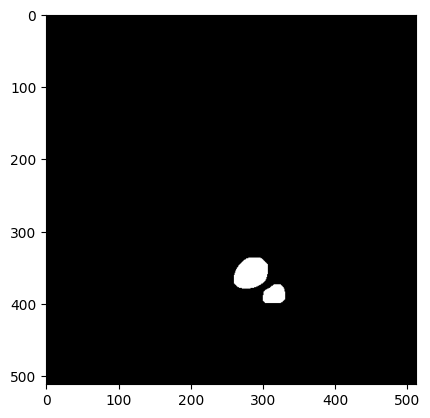

In [29]:
plt.imshow(mask_4[:,:,0],cmap='gray')
plt.show()


Number of connected components: 3
Tibia found...
Areas of components: {1: np.int64(717), 2: np.int64(1), 3: np.int64(121)}
Tibia is component 1 with area 717


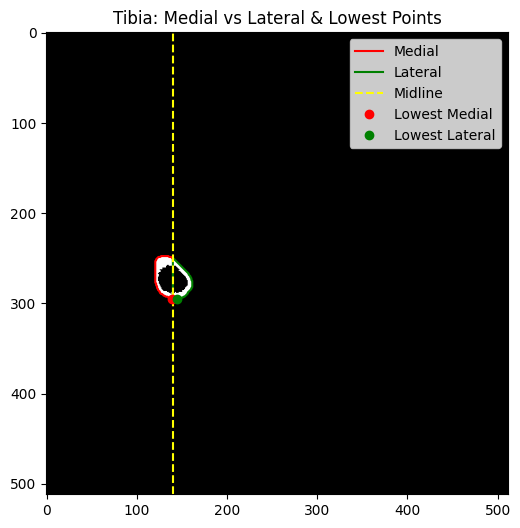

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import label

def find_largest_contour(mask_slice): 
    contours = measure.find_contours(mask_slice, level=0.5)
    return max(contours, key=len)

# Label connected components
labeled_array, num_features = label(original_masks[:, :, 60])
labeled_array = np.rot90(labeled_array, k=-1)  # rotate to match orientation

print("Number of connected components:", num_features)

if num_features == 1:
    print('Tibia not found...')
else:
    print('Tibia found...')
    area = {i: (labeled_array == i).sum() for i in range(1, num_features + 1)}
    print("Areas of components:", area)
    
    # Identify tibia as the largest component
    tibia_label = max(area, key=area.get)
    print(f'Tibia is component {tibia_label} with area {area[tibia_label]}')

    # Mask out non-tibia
    labeled_array[labeled_array != tibia_label] = 0

    mask_slice = labeled_array
    contour = find_largest_contour(mask_slice)

    mid_x = np.mean(contour[:, 1])

    # Split into medial and lateral parts
    medial = contour[contour[:, 1] < mid_x]
    lateral = contour[contour[:, 1] >= mid_x]

    # Find lowest point (max Y) in medial and lateral
    medial_lowest = medial[np.argmax(medial[:, 0])]
    lateral_lowest = lateral[np.argmax(lateral[:, 0])]

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_slice, cmap='gray')
    plt.plot(medial[:, 1], medial[:, 0], 'r', linewidth=1.5, label='Medial')
    plt.plot(lateral[:, 1], lateral[:, 0], 'g', linewidth=1.5, label='Lateral')
    plt.axvline(x=mid_x, color='yellow', linestyle='--', label='Midline')

    # Plot lowest points
    plt.plot(medial_lowest[1], medial_lowest[0], 'ro', label='Lowest Medial')
    plt.plot(lateral_lowest[1], lateral_lowest[0], 'go', label='Lowest Lateral')

    plt.legend()
    plt.title("Tibia: Medial vs Lateral & Lowest Points")
    plt.show()
